=======================================================================================

# TP de Statistique Bayésienne

# Version étudiant
=======================================================================================

Dans ce TP, nous allons mettre en place quelques procédures de calcul bayésien dans 
un cas conjugué : la loi du posterior appartient à la même classe que la loi du prior

In [1]:
#%matplotlib notebook
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from scipy import stats

## Loi exponentielle (modèle de durée de vie)

Définir une fonction, prenant comme arguments *(a,n,lambda0,lambda1)*, qui : 
- simule n données de loi exponentielle *E(lambda0)*
- trace la vraisemblance sur l'axe des lambda 
- trace sur ce même axe une densité a priori de loi **gamma G(a,b)** pour lambda, en fixant l'espérance de cette loi a lambda1
- trace sur ce même axe la densité a posteriori de lambda

Modifiez les paramètres d'entrée ; comment évolue la loi a posteriori vis-à-vis de la vraisemblance et de la loi a priori ?

Quel sens pouvons-nous donner aux hyperparamètres **a** et **b** ? 

Faites tendre **a** et **b** vers 0. Que se passe-t-il ? 

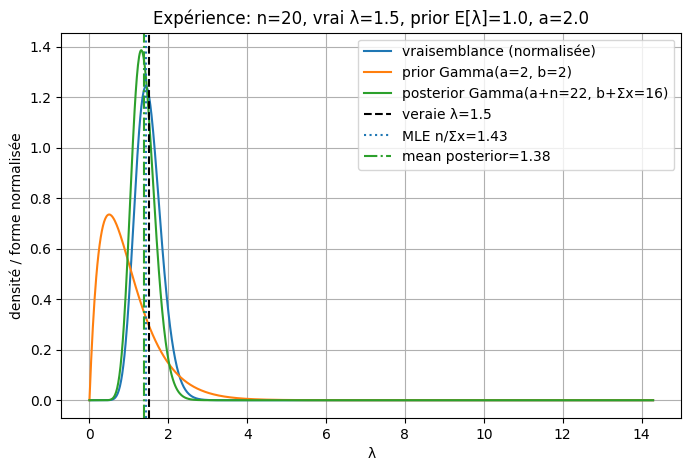

In [2]:
def plot_exp_posterior(a, n, lambda0, lambda1, lamb_max=None, grid=1000, random_state=None):
    """
    Simule n observations X_i ~ Exp(lambda0) et trace sur l'axe des lambda :
      - la vraisemblance (normalisée pour comparaison visuelle),
      - la densité a priori Gamma(a,b) avec b = a/lambda1 (donc E[lambda]=lambda1),
      - la densité a posteriori Gamma(a+n, b+sum(x)).
    
    Arguments
    - a, n, lambda0, lambda1 : scalaires (a>0, n>0, lambda0>0, lambda1>0)
    - lamb_max : borne supérieure pour l'axe des lambda (optionnel)
    - grid : nombre de points sur l'axe des lambda
    - random_state : entier pour reproductibilité (optionnel)
    
    Retourne : tuple (x, lam_grid, likelihood_norm, prior, posterior, post_params)
    """
    if a <= 0 or n <= 0 or lambda0 <= 0 or lambda1 <= 0:
        raise ValueError("a, n, lambda0 et lambda1 doivent être > 0 (utilisez des valeurs très petites pour approcher 0).")
    rng = np.random.default_rng(random_state)
    # simuler données
    x = rng.exponential(scale=1.0 / lambda0, size=n)
    sum_x = x.sum()
    # prior rate b fixé par l'espérance lambda1 = a / b -> b = a / lambda1
    b = a / lambda1
    # paramètres postérieurs (conjugaison)
    a_post = a + n
    b_post = b + sum_x

    # choisir grille de lambdas
    if lamb_max is None:
        # on prend une borne raisonnable autour du vrai lambda et de la moyenne postérieure
        post_mean = a_post / b_post
        lam_max = max(lambda0 * 3.0, post_mean * 5.0, 10.0 * (1.0 / np.maximum(1e-3, x.mean())))
    lam = np.linspace(1e-8, lam_max, grid)

    # vraisemblance non normalisée et normalisée (pour comparer formes)
    lik = lam**n * np.exp(-lam * sum_x)
    lik_area = np.trapz(lik, lam)
    lik_norm = lik / lik_area if lik_area > 0 else lik

    # densités prior et post (scipy.stats.gamma uses shape k and scale theta=1/rate)
    prior = stats.gamma.pdf(lam, a, scale=1.0 / b)
    post = stats.gamma.pdf(lam, a_post, scale=1.0 / b_post)

    # points d'intérêt
    mle = n / sum_x
    post_mean = a_post / b_post

    # tracé
    pl.figure(figsize=(8, 5))
    pl.plot(lam, lik_norm, label='vraisemblance (normalisée)', color='C0')
    pl.plot(lam, prior, label=f'prior Gamma(a={a:.3g}, b={b:.3g})', color='C1')
    pl.plot(lam, post, label=f'posterior Gamma(a+n={a_post:.3g}, b+Σx={b_post:.3g})', color='C2')
    pl.axvline(lambda0, color='k', linestyle='--', label=f'veraie λ={lambda0:.3g}')
    pl.axvline(mle, color='C0', linestyle=':', label=f'MLE n/Σx={mle:.3g}')
    pl.axvline(post_mean, color='C2', linestyle='-.', label=f'mean posterior={post_mean:.3g}')
    pl.xlabel('λ')
    pl.ylabel('densité / forme normalisée')
    pl.title(f'Expérience: n={n}, vrai λ={lambda0}, prior E[λ]={lambda1}, a={a}')
    pl.legend()
    pl.grid(True)
    pl.show()

    return x, lam, lik_norm, prior, post, (a_post, b_post)

# Exemple d'utilisation
a = 2.0
n = 20
lambda0 = 1.5
lambda1 = 1.0
x, lam_grid, likelihood_norm, prior, posterior, post_params = plot_exp_posterior(a, n, lambda0, lambda1, random_state=42)